# Gaussian Naive Bayes Classifier

The aim of this project is to implement and test a Guassian Naive Bayes classifier.

In [169]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
import timeit

%matplotlib inline

## GaussianNB Classifier
An implementation of a Gaussian Naive Bayes that fits the framework.

In [170]:
class MyGaussianNB(BaseEstimator, ClassifierMixin):
    def fit(self, xt, yt):
        xt = np.array(xt)
        yt = np.array(yt)

        # first phase: compute class priors
        self._classes, self._class_priors = np.unique(yt, return_counts=True)
        self._class_priors = self._class_priors / float(np.sum(self._class_priors))  

        # second phase: compute all features' means and variances
        xt_split = [xt[yt==cl] for cl in self._classes]
        self._means = np.array([np.mean(xtcl, axis=0) for xtcl in xt_split])
        self._vars = np.array([np.var(xtcl, axis=0) for xtcl in xt_split])
        return self

    def predict(self, xtests):
        xtests = np.array(xtests)

        probas = self._compute_probas(xtests)
        return np.array([self._classes[i] for i in np.argmax(probas, axis=0)])

    def _compute_probas(self, xtests):
        return np.array([
            [
                self._class_priors[i] * np.product(self._conditional_proba(xtest, self._means[i], self._vars[i])) 
                for xtest in xtests
            ]
            for i in range(np.size(self._classes))
        ])
    
    @staticmethod
    def _conditional_proba(xt, m, var):
        return np.exp(-np.power(xt-m, 2)/(2*var))/np.sqrt(2*np.pi*var)

The function below will compare Scikit Gaussian NB and my implementation of Gaussian NB using accuracy and ROC analysis.

In [171]:
def test_gaussian_on_dataset(x_train, y_train, x_test, y_test):
    X = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Not Helpful', 'Helpful'])
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title("Scikit GNB Confusion Matrix")
    disp.plot(ax=ax)

    print(f"Scikit GNB - Report:\n{report}")

    data = []
    for scoring in ['accuracy', 'f1', 'precision', 'recall']:
        data.append({key: score.mean() for (key, score) in cross_validate(gnb, X, y, scoring=scoring).items()})
    print()
    print('CV x5 Scikit GNB: ')
    print(pd.DataFrame(data=data, columns=['test_score', 'fit_time', 'score_time'], index=['accuracy', 'f1', 'precision', 'recall']))
    print()
    
    mgnb = MyGaussianNB()
    mgnb.fit(x_train,y_train)
    y_pred = mgnb.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Not Helpful', 'Helpful'])
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title("My GNB Confusion Matrix")
    disp.plot(ax=ax)

    print(f"My GNB - Report:\n{report}")
    
    results = []
    for scoring in ['accuracy', 'f1', 'precision', 'recall']:
        results.append({key: score.mean() for (key, score) in cross_validate(mgnb, X, y, scoring=scoring).items()})
    print()
    print('CV x5 My GNB: ')
    print(pd.DataFrame(data=results, columns=['test_score', 'fit_time', 'score_time'], index=['accuracy', 'f1', 'precision', 'recall']))
    print()


This function below will compare Scikit's Gaussian NB and mine in terms of speed.

In [172]:
def test_speed_on_dataset(x_train, y_train, x_test, y_test, repeat=100):
    gnb = GaussianNB()
    gnb_fit_time = timeit.timeit(lambda: gnb.fit(x_train, y_train), number=repeat)
    gnb_predict_time = timeit.timeit(lambda: gnb.predict(x_test), number=repeat)
    
    print(f'Scikit GNB fit performance: {gnb_fit_time}s ({repeat} times)')
    print(f'Scikit GNB predict performance: {gnb_predict_time}s ({repeat} times)')

    mgnb = MyGaussianNB()
    mgnb_fit_time = timeit.timeit(lambda: mgnb.fit(x_train, y_train), number=repeat)
    mgnb_predict_time = timeit.timeit(lambda: mgnb.predict(x_test), number=repeat)

    print(f'My GNB fit performance: {mgnb_fit_time}s ({repeat} times)')
    print(f'My GNB predict performance: {mgnb_predict_time}s ({repeat} times)')

## Penguins dataset
Running and testing Gaussian Naive Bayes on the penguin dataset.

In [173]:
penguins_af = pd.read_csv('penguins_af.csv', index_col = 0)
print(penguins_af.shape)
penguins_af.head()

(333, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [174]:
penguins_af['target'] = np.where(penguins_af['species'] == 'Adelie', 1, 0)
f_names = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g', 'species', 'target']
penguins = penguins_af[f_names]
penguins2C = penguins.loc[penguins['species'].isin(['Adelie','Chinstrap'])]
penguins2C.pop('species')
penguins2C.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,target
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,1
2,40.3,18.0,195.0,3250.0,1
4,36.7,19.3,193.0,3450.0,1
5,39.3,20.6,190.0,3650.0,1


In [175]:
y = penguins2C.pop('target').values
X_raw = penguins2C.values
feature_names = penguins2C.columns
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
X_train.shape, X_test.shape

((107, 4), (107, 4))

Scikit GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.97      0.97      0.97        39
     Helpful       0.99      0.99      0.99        68

    accuracy                           0.98       107
   macro avg       0.98      0.98      0.98       107
weighted avg       0.98      0.98      0.98       107

Scikit GNB - Accuracy:	0.9813084112149533
Scikit GNB - F1 Score:	0.9852941176470589
CV x5 Scikit GNB: 
           test_score  fit_time  score_time
accuracy     0.953488  0.000800    0.000400
f1           0.965634  0.000799    0.000800
precision    0.965484  0.000999    0.001001
recall       0.966437  0.000798    0.000802

My GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.97      0.97      0.97        39
     Helpful       0.99      0.99      0.99        68

    accuracy                           0.98       107
   macro avg       0.98      0.98      0.98       107
weighted avg       0.98      0.98      

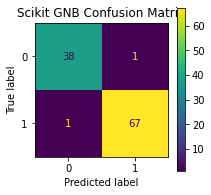

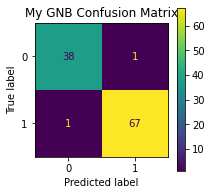

In [176]:
test_gaussian_on_dataset(X_train, y_train, X_test, y_test)

In [177]:
test_speed_on_dataset(X_train, y_train, X_test, y_test)

Scikit GNB fit performance: 0.05751629999997476s (100 times)
Scikit GNB predict performance: 0.012263099999927363s (100 times)
My GNB fit performance: 0.01788859999999204s (100 times)
My GNB predict performance: 0.3623883999999862s (100 times)


## Diabetes dataset
Running and testing Gaussian Naive Bayes on the diabetes test dataset.

In [178]:
diabetes = pd.read_csv('diabetes.csv', index_col = 0)
print(diabetes.shape)
diabetes.head()

(768, 8)


,plas,pres,skin,insu,mass,pedi,age,neg_pos
preg,,,,,,,,
6,148,72,35,0,33.6,0.627,50,tested_positive
1,85,66,29,0,26.6,0.351,31,tested_negative
8,183,64,0,0,23.3,0.672,32,tested_positive
1,89,66,23,94,28.1,0.167,21,tested_negative
0,137,40,35,168,43.1,2.288,33,tested_positive


In [179]:
diabetes['target'] = np.where(diabetes['neg_pos'] == 'tested_positive', 1, 0)
diabetes.pop('neg_pos').values
diabetes.head()

,plas,pres,skin,insu,mass,pedi,age,target
preg,,,,,,,,
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


In [180]:
y = diabetes.pop('target').values
Xorig = diabetes.values
scaler = StandardScaler()
X = scaler.fit_transform(Xorig)
X.shape, y.shape

((768, 7), (768,))

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

Scikit GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.80      0.88      0.84       170
     Helpful       0.71      0.57      0.63        86

    accuracy                           0.78       256
   macro avg       0.76      0.73      0.74       256
weighted avg       0.77      0.78      0.77       256

Scikit GNB - Accuracy:	0.77734375
Scikit GNB - F1 Score:	0.632258064516129
CV x5 Scikit GNB: 
           test_score  fit_time  score_time
accuracy     0.751320  0.000800    0.000400
f1           0.606730  0.000797    0.000803
precision    0.684469  0.001048    0.000952
recall       0.552061  0.000799    0.001201

My GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.80      0.88      0.84       170
     Helpful       0.71      0.57      0.63        86

    accuracy                           0.78       256
   macro avg       0.76      0.73      0.74       256
weighted avg       0.77      0.78      0.77     

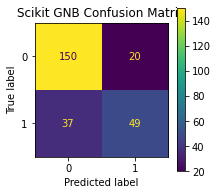

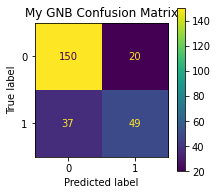

In [182]:
test_gaussian_on_dataset(X_train, y_train, X_test, y_test)

In [183]:
test_speed_on_dataset(X_train, y_train, X_test, y_test)

Scikit GNB fit performance: 0.06605409999997391s (100 times)
Scikit GNB predict performance: 0.015075700000011238s (100 times)
My GNB fit performance: 0.02581190000000788s (100 times)
My GNB predict performance: 0.743267699999933s (100 times)


## Hotel Reviews dataset
Running and testing Gaussian Naive Bayes on the helpfulness of hotel reviews dataset.

In [184]:
reviews = pd.read_csv('HotelRevHelpfulness.csv', index_col=0)
print(reviews.shape)
reviews.head()

(486, 24)


,aveHelpfulnessRatioUser,stdevHelpfulnessRatioUser,pcReviewsExceedMinHelpfulnessSupport,numReviewsUser,numReviewsHotel,ratingUser,numberSubRatingsUser,subRatingMeanUser,subRatingStdevUser,aveRatingUser,...,completeness_2,completeness_3,numberTermsEntry,percentageAlphaCharsEntry,fractionUpperCaseCharsEntry,fractionYouVsIEntry,numberTermsSummaryQuote,percentageAlphaCharsSummaryQuote,fractionUpperCaseCharsSummaryQuote,reviewHelpfulness
hotelId,,,,,,,,,,,,,,,,,,,,,
17420,1.000000,0.000000,0.666667,3,16,5,4,4.000000,0.000000,4.333333,...,0,1,182,0.788474,0.025703,0.500000,6,0.815789,0.096774,1
1397,0.772487,0.377321,0.500000,12,233,5,0,0.000000,0.000000,4.333333,...,0,0,158,0.791888,0.012594,0.500000,1,1.000000,0.083333,1
1348,0.715473,0.300437,0.833333,12,302,4,7,3.714286,0.755929,4.166667,...,0,3,59,0.799639,0.024831,0.333333,4,0.828571,0.034483,0
5940,0.521250,0.481675,0.222222,36,6,1,4,1.000000,0.000000,3.527778,...,0,0,95,0.782212,0.029155,0.500000,2,0.800000,0.062500,0
38,0.603175,0.246926,1.000000,2,271,3,0,0.000000,0.000000,3.500000,...,0,0,43,0.805128,0.028662,0.000000,1,1.000000,0.142857,0


In [185]:
y = reviews.pop('reviewHelpfulness').values
x_raw = reviews.values
scaler = StandardScaler()
x = scaler.fit_transform(x_raw)

In [186]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/3)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((324, 23), (324,), (162, 23), (162,))

Scikit GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.62      0.46      0.53        52
     Helpful       0.77      0.86      0.82       110

    accuracy                           0.73       162
   macro avg       0.69      0.66      0.67       162
weighted avg       0.72      0.73      0.72       162

Scikit GNB - Accuracy:	0.7345679012345679
Scikit GNB - F1 Score:	0.815450643776824
CV x5 Scikit GNB: 
           test_score  fit_time  score_time
accuracy     0.638018  0.001004    0.000380
f1           0.710162  0.000519    0.001205
precision    0.720466  0.001000    0.001000
recall       0.705077  0.001000    0.001000

My GNB - Report:
              precision    recall  f1-score   support

 Not Helpful       0.62      0.46      0.53        52
     Helpful       0.77      0.86      0.82       110

    accuracy                           0.73       162
   macro avg       0.69      0.66      0.67       162
weighted avg       0.72      0.73      0

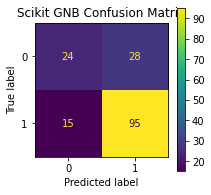

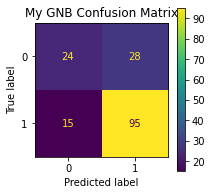

In [187]:
test_gaussian_on_dataset(x_train, y_train, x_test, y_test)

In [188]:
test_speed_on_dataset(x_train, y_train, x_test, y_test)

Scikit GNB fit performance: 0.08169139999995423s (100 times)
Scikit GNB predict performance: 0.02613050000002204s (100 times)
My GNB fit performance: 0.025861900000109017s (100 times)
My GNB predict performance: 0.5594022000000223s (100 times)


# Conclusion

For binary classification:

- Evaluation: 

  - their confusion matrices are equals ;
  - their accuracies, f1 scores, recall and precisions are equals for the 3 datasets ;

- Speed:

  - `fit` method: Scikit is slower than mine (about 4 times) ;
  - `predict` method: Scikit is faster than mine (about 40 times).

- What I suspect for these differences:

  - Scikit may compute other values when fitting the model in order to optimize the predictions ;
  - Scikit may use a better but equivalent algorithm to compute the conditional probabilities.